In [2]:
# Downlod the dataset
! rm -rf data
! rm *.csv*
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_custom.csv
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_custom.csv
! mkdir -p data
! mv *.csv data/


rm: cannot remove '*.csv*': No such file or directory
--2020-08-02 00:57:40--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_custom.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4111913 (3.9M) [text/csv]
Saving to: ‘test_custom.csv’

test_custom.csv     100%[===================>]   3.92M  --.-KB/s    in 0.04s   

2020-08-02 00:57:40 (108 MB/s) - ‘test_custom.csv’ saved [4111913/4111913]

--2020-08-02 00:57:41--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_custom.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 2

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D, MaxPooling1D
import matplotlib.pyplot as plt
import csv
import numpy as np

In [4]:
class BatchGenerator:

    def __init__(self, data_path, batch_size):
        self.batch_size = batch_size
        self.data_path = data_path
        self.n_labels = 20

    def get_batch_gen(self, repeat=True):
        while True:
            with open(self.data_path) as data_file:
                reader = csv.reader(data_file)
                batch = []
                for row in reader:  # TODO: Can the next batch be fetched asynchronously? With asyncio?
                    batch.append(row)
                    if len(batch) >= self.batch_size:
                        batch = self._split_batch(batch)
                        yield batch
                        batch = []
                if 0 < len(batch) < self.batch_size:
                    yield self._split_batch(batch)
            if not repeat:
                break

    def _split_batch(self, batch):
        batch = np.array(batch, dtype=int)
        x = batch[:, :len(batch[0]) - self.n_labels]
        y = batch[:, len(batch[0]) - self.n_labels:]
        return x, y


In [5]:
train_batch_size = 30
test_batch_size = 30
train_size = 11083
test_size = 7761
train_steps = train_size / train_batch_size
test_steps = test_size / test_batch_size

train_gen = BatchGenerator(data_path='data/train_custom.csv', batch_size=train_batch_size).get_batch_gen()
test_gen = BatchGenerator(data_path='data/test_custom.csv', batch_size=test_batch_size).get_batch_gen()

In [6]:
vocab_size = 10000
embed_size = 64

In [23]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embed_size, input_length=150),
    Conv1D(64, 5, activation='relu'),
    Dropout(0.3),
    MaxPooling1D(2),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    MaxPooling1D(2),
    Conv1D(256, 5, activation='relu'),
    Dropout(0.3),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 64)           640000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 146, 64)           20544     
_________________________________________________________________
dropout_17 (Dropout)         (None, 146, 64)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 69, 128)           41088     
_________________________________________________________________
dropout_18 (Dropout)         (None, 69, 128)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 34, 128)          

In [24]:
epochs = 30
history = model.fit(
    train_gen, steps_per_epoch=train_steps, epochs=epochs,
    validation_data=test_gen, validation_steps=test_steps)

Epoch 1/30
370/369 [==============================] - 5s 15ms/step - loss: 2.6612 - accuracy: 0.1152 - val_loss: 2.4426 - val_accuracy: 0.2040
Epoch 2/30
370/369 [==============================] - 5s 14ms/step - loss: 1.9125 - accuracy: 0.3164 - val_loss: 1.9013 - val_accuracy: 0.3601
Epoch 3/30
370/369 [==============================] - 5s 14ms/step - loss: 1.2968 - accuracy: 0.5360 - val_loss: 1.6554 - val_accuracy: 0.4306
Epoch 4/30
370/369 [==============================] - 5s 14ms/step - loss: 0.9165 - accuracy: 0.6602 - val_loss: 1.5626 - val_accuracy: 0.4729
Epoch 5/30
370/369 [==============================] - 5s 14ms/step - loss: 0.7153 - accuracy: 0.7427 - val_loss: 1.6141 - val_accuracy: 0.5017
Epoch 6/30
370/369 [==============================] - 5s 14ms/step - loss: 0.5509 - accuracy: 0.8001 - val_loss: 1.6808 - val_accuracy: 0.5245
Epoch 7/30
370/369 [==============================] - 5s 14ms/step - loss: 0.4283 - accuracy: 0.8490 - val_loss: 1.5974 - val_accuracy: 0.5816

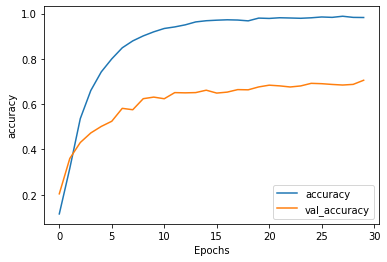

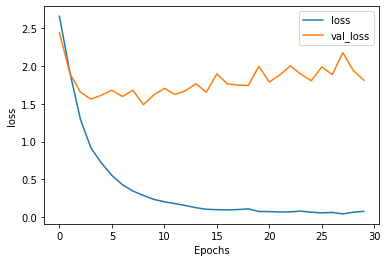

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [ ]:
model.save('linear.h5')

In [ ]:
from google.colab import files
files.download('linear.h5')